# 1. 매개변수 갱신
- optimization 문제: 신경망 최적화는 수식을 풀어서 순식간에 최소값을 구하는 방법은 없다.

## 1. SGD

In [58]:
%%latex

$$ W \leftarrow W - \gamma * \frac{\partial L}{\partial W} $$

<IPython.core.display.Latex object>

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

- 예시 코드

network = TwoLayerNet()

optimizer = SGD()

for i in range(10000):

    x_batch, t_batch = get_mini_batch()
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params, grads)

### SGD 단점: 비등방성 함수에서는 탐색 경로가 비효율적이다.

In [31]:
%%latex

$$f(x,y) = 1/20 * x^2 + y^2 의 기울기는 y 축 방향으로 크고 x 축 방향으로 작다. $$
$$f(x)가 최소값이 되는 장소는 (x, y) = (0, 0)이지만 기울기 대부분은 (0, 0) 방향을 가리키지 않는다. $$

<IPython.core.display.Latex object>

## 2. 모멘텀

In [57]:
%%latex

$$ v \leftarrow  \alpha * v - \gamma * \frac{\partial L}{\partial W}$$
$$ W \leftarrow W + v$$

<IPython.core.display.Latex object>

v 변수가 새로 나오는데, 이는 물리학에서 말하는 속도에 해당한다. 또 alpha * v 항은 물체가 아무런 힘을 받지 않을 떄 서서히 하강하는 역할을 한다.

In [46]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            # X축 으로 계속해서 일정하게 이동하도록 돕는다. (왜냐하면 기존의 x 축 방향의 속도를 유지한 채로 계속 다가간다.)
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

- x 축의 힘은 작지만 위아래로 번갈아 받아서 상충하여 y축 방향의 속도는 안정적이지 않다.

## 3. AdaGrad

-  신경망 학습에서는 학습률 값이 가장 중요합니다. 이 값이 너무 작으면 학습 시간이 길어지고, 반대로 너무 크면 발산하여 학습이 제대로 이루어지지 않습니다. 이 학습률을 정하는 효과적 기술로 학습률 감소가 있습니다. (learning rate decay) 처음에는 크게 학습하다가 조금씩 작게 학습한다는 얘기로 실제 신경망 학습에 자주 쓰입니다.

- 학습률을 서서히 낮추는 가장 간단한 방법은 매개변수 전체의 학습률 값을 일괄적으로 낮추는 것이다. 이를 더욱 발전시킨 것이 AdaGrad이다. AdaGrad는 각각의 매개변수에 맞춤형 값을 만들어줍니다.

- AdaGrad는 개별 매개변수에 적응적으로 학습률을 조정하면서 학습을 진행합니다. AdaGrad의 갱신 방법은 수식 적으로는 다음과 같습니다.

In [65]:
%%latex 

$$ h \leftarrow h + \frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W} $$
$$ W \leftarrow W - \gamma * 1 / \sqrt{h} * \frac{\partial L}{\partial W} $$

<IPython.core.display.Latex object>

h에서 보듯 기존 기울기 값을 제곱해서 계속 더해줍니다. 그리고 매개변수를 갱신할 때 1 / h^1/2 을 곱해 학습률을 조정합니다. 매개변수의 원소 중에서 많이 움직인 원소는 학습률이 낮아진다는 뜻인데, 다시 말해 학습률 갑소가 매개변수 원소마다 다르게 적용된다.

Adagrad가 어느 순간 갱신량이 0이 되는 것을 방지하기 위해서 개선한 기법으로 RMSProp이 있다. RMSProp은 과거의 모든 기울기를 더해가는 것이 아니라 먼 과걱의 기울기는 서서히 잊고 새로운 기울기 정보를 크게 반영한다. 이를 지수이동평균이라 하여 과거 기울기 반영 규모를 기하급수적으로 감소시킵니다.

In [66]:
class Adagrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            
        for key, val in params.items():
            self.h[key] = np.zeros_like(val)
            
        for key, val in params.keys():
            params[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [67]:
class RMSprop:
    """RMSprop"""
    def __init__(self, lr=0.01, decay_rate = 0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            # 과거의 기울기
            self.h[key] *= self.decay_rate
            
            # 현재 기울기
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


## 4. Adam

- 모멘텀은 공이 그릇 바닥을 구르는 듯한 움직임을 보였다. AdaGrad는 매개변순의 원소마다 적응적으로 갱신 정도를 조정했다. 그럼 혹시 두 기법을 융합하면 어떻게 될까? 직관적으로 Adam은 Momentum과 Adagrad의 융합이다. 또 하이퍼파라미터의 편향 보정이 진행된다.

In [68]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

# 2. 가중치 초기값

### 1. 초기값

- 가중치 초기값을 모두 0으로 설정하면 안 좋다. 그 이유는 오차 역전파 법에서 모든 가중치의 값이 똑같이 갱신되기 때문이다. 두 번째 층의 모든 뉴런에 같은 값이 입력된다는 것은 역전파 때 두 번째 층의 모든 뉴런에 같은 값이 입력돤다는 것은 역전파 때 두 번째 층의 가중치가 모두 똑같이 갱신된다는 것이다. 이는 가중치를 여러 개 갖는 의미를 없앤다. 이 가중치가 고르게 되어버리는 상황을 막으려면 초기값을 무작위로 설정해야 한다.

### 2. 은닉층의 활성화 값 분포

### 1. 기울기 소실

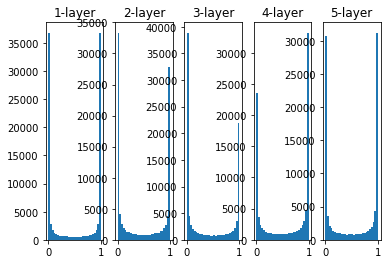

In [79]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x,w)
    z = sigmoid(a)
    activations[i] = z
    
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
    
plt.show()

### 2. 표현력 제한

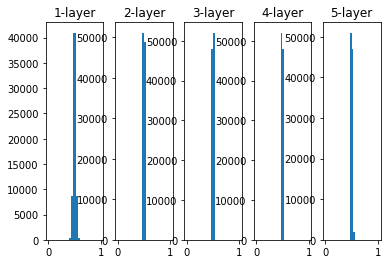

In [80]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    #w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01
    a = np.dot(x,w)
    z = sigmoid(a)
    activations[i] = z
    
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
    
plt.show()

### 3. Xavier

- 앞 층의 노드가 n 개라면 표준편차가 1/sqrt(n) 인 분포를 사용한다.

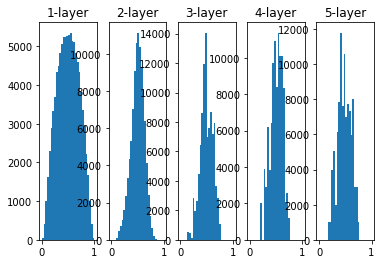

In [81]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    #w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    a = np.dot(x,w)
    z = sigmoid(a)
    activations[i] = z
    
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
    
plt.show()

### 4. Relu: He 초기화

- 활성화 함수로 ReLU로 사용할 때는 HE 초기값을 아니면 Xavier 초기값을 사용한다. 현재의 모범사례이다.

# 3. Batch Normalization

- 학습을 빨리 진행할 수 있다.
- 초기값에 의존하지 않는다. (골치 아픈 초기값 선택 장애 안녕!)
- 오버피팅을 억제한다.

미니 배치 m 개의 입력 데이터의 집합에 대해 평균 mu와 분산 sigma^2을 구합니다. 그리고 입력 데이터를 평균이 0, 분산이 1이 되게 정규화합니다. 그리고 e 기호는 작은 값으로, 0으로 나누는 사태를 예방하는 역할입니다. 배치 정규화에는 감마와 베타라는 parameter가 있어서 이를 학습한다.

# 4. 바른 학습

Overfitting은 주로 다음 경우에 나타난다.

- 매개변수가 많고 표현력이 높은 모델
- 훈련 데이터가 적다.

## 1. 가중치 감소

- weight decay: L2 nrom, L1 nrom

## 2. 드롭아웃

In [82]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flag=True):
        if train_flag:
            self.mask = np.random.rand(x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
        
    # 순전파에도 통과시키지 않은 뉴런은 역전파 떄도 신호를 차단한다. 
    def backward(self, dout):
        return dout * self.mask

# 5. Hyperparameter 값 탐색

- 하이퍼파라미터 값 탐색은 최적 값이 존재할 범위를 점차 좁히면서 하는 것이 효과적이다.